Domande Gaspare: 
1. è il cazzo di pseudocodice sulla funzione di anonimizzazione a coppie giusto?
2. nello pseudocodice non si accenna mai all'aggiunta degli edge durante la BFS, MAI

Cose da fare:
- funzioni da testare: most_similar_component, match_and_generalize_components, update_graph, build_component, anonymize_pair, anonymize_graph
- rendere deterministico il codice (e.g., ordinamento di VertexList fatto in 2 punti)

# **DPP - Progetto**

## Data Generation

"In this paper, we model a social network as a simple graph G = (V, E, L, *L*), where V is a set of vertices, E ⊆ V × V is a set of edges, L is a set of labels, and a labeling function *L* : V → L assigns each vertex a label. [...] To keep our discussion simple, we assume that edges do not carry labels. [...]     
The items in the label set L form a hierarchy. For example, if occupations are used as labels of vertices in a social network, L contains not only the specific occupations such as dentist, general physician, optometrist, high school teacher, and primary school teacher, but also general categories like medical doctor, teacher, and professional. We assume that there exists a meta symbol ∗ ∈ L which is the most general category generalizing all labels. For two labels l1, l2 ∈ L, if l1 is more general than l2, we write l1 ≺ l2. For example, medical doctor ≺ optometrist. Moreover, l1 ≺= l2 if and only if l1 ≺ l2 or l1 = l2. ≺= is a partial order on L."    
**Workflow**   
- Generate the graph (with R-MAT or) with Barabasi-Albert graph model
- Post-assign labels or attributes according to a custom _L_, for example:
    - randomly (X)
    - based on degree
    - based on inferred communities
    - from external metadata

In [1]:
# ORIGINAL GRAPH TO PROTECT
import networkx as nx

# synthetic undirected graph generation
n = 100
m = 5
G = nx.barabasi_albert_graph(n=n, m=m, seed=42)
print(f"Number of nodes : {len(G.nodes())}")
print(f"Number of edges : {len(G.edges())}")

# importazione di un grafo reale (social network)

Number of nodes : 100
Number of edges : 475


In [3]:
# label domain class definition 
class LabelDomain():
    def __init__(self, labels, children, root):
        self.labels = labels
        self.root = root
        self.children = children # dict mapping node to children
        self.parent = self._build_parent_map()

    def _build_parent_map(self):
        parent = {self.root: None}
        for p, children in self.children.items():
            for c in children:
                parent[c] = p
        return parent

    def size(self, l):
        if not self.children[l]:
            return 1 # it's a leaf
        
        # Recursive case: sum leaf counts of all children
        return sum(self.size(child_label) for child_label in self.children[l])
    
    def is_leaf(self, l):
        return not self.children[l] # no children

    def normalized_certainty_penalty(self, l): # from 0 (a leaf, max certainty) to 1 (most general label, min certainty)
        return self.size(l) / self.size(self.root)
    
    def find_label_common_parent(self, l1, l2):
        if l1 not in self.labels or l2 not in self.labels:
            return None

        ancestors = []
        current = l1

        # Traverse from l1 up to the root
        while current != '*':
            ancestors.append(current)
            current = self.parent[current]

        ancestors.append('*')

        # Traverse from l2 up to the first common label found
        current = l2
        while current != '*':
            if current in ancestors:
                return current
            current = self.parent[current]

        # If no match is found, return the root
        return '*'

In [4]:
# plain toy dict of children
children = {
    # root 
    "*": ["Medical Doctor", "Teacher"],
    # depth 1
    "Medical Doctor": ["Dentist", "General Physician", "Optometrist"],
    "Teacher": ["High School Teacher", "Primary School Teacher"],
    # depth 2
    "Dentist": [],
    "General Physician": [],
    "Optometrist": [],
    "High School Teacher": [],
    "Primary School Teacher": []
}

# set
labels = set(children.keys())
root = "*"

label_domain = LabelDomain(labels, children, "*") # the root is always the * symbol

In [5]:
import random

#TODO: to start simple, assume to assign as labels only the leaves, but in principle, we could assign also intermediate nodes
def assign_randomly_leaf_labels(G, label_domain):
    G.graph['labels'] = label_domain.labels 
    leaf_labels = [l for l in label_domain.children if not label_domain.children[l]]  # all leaves
    for node in G.nodes():
        G.nodes[node]['label'] = random.choice(leaf_labels)
    return G

G = assign_randomly_leaf_labels(G, label_domain)

In [6]:
# DEBUG CODE
random_nodes = random.sample(list(G.nodes()), 5)
for n in random_nodes:
    print(n, G.nodes[n]['label'])

0 Primary School Teacher
38 High School Teacher
26 Primary School Teacher
90 Dentist
57 Optometrist


As reported in the paper, two main properties are recurrent in social networks:   
- **Property 1.** vertex degree in power law distribution
- **Property 2.** the "small-world phenomenon"     

Are those satisfied in our networks?

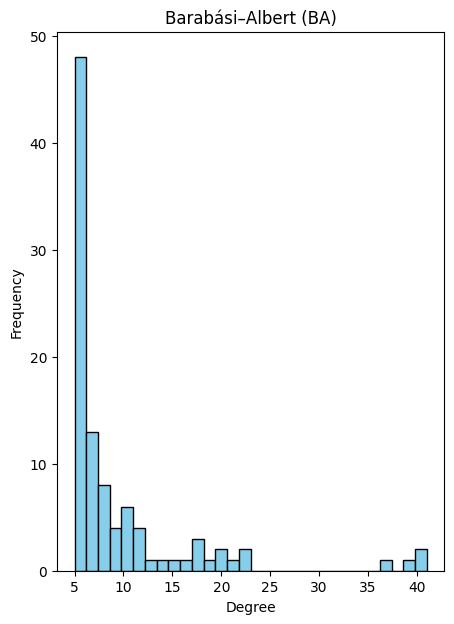

Average diameter:  2.16969696969697


In [6]:
import matplotlib.pyplot as plt

# plot the degree distribution of the networks
plt.figure(figsize=(5, 7))
plt.title("Barabási–Albert (BA)")
degrees_ba = [d for n, d in G.degree()]
plt.hist(degrees_ba, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# compute the average diameter of the network
avg_path_length = nx.average_shortest_path_length(G)
print("Average diameter: ", avg_path_length)

Both properties are satisfied. 

## Anonymization algorithm implementation    

In [7]:
def dfs(G: nx.Graph): # deterministc & tested
    tick = [0]  # mutable counter, for proper update with many recursions 
    visited = set()
    dfs_time = {}
    dfs_edges = {}

    for u, v in G.edges():
         dfs_edges[tuple(sorted([u, v]))] = False # default: backward edges
    for node in sorted(G.nodes()):
        if node not in visited:
            dfs_visit(G, node, tick, dfs_time, visited, dfs_edges)
    
    return dfs_time, dfs_edges

def dfs_visit(G: nx.Graph, node: int, tick: list, dfs_time: dict, visited: set, dfs_edges: dict): # deterministc & tested
    visited.add(node)
    tick[0] += 1
    dfs_time[node] = tick[0]
    for neighbor in sorted(G.neighbors(node)):
        if neighbor not in visited:
            dfs_edges[tuple(sorted([node, neighbor]))] = True
            dfs_visit(G, neighbor, tick, dfs_time, visited, dfs_edges)

In [8]:
# DEBUG CODE
import networkx as nx
myG = nx.Graph()
myG.add_nodes_from(range(1, 6))
myG.add_edges_from([(1, 4), (1, 2), (2, 3), (3, 4), (4, 5)])
myG = assign_randomly_leaf_labels(myG, label_domain)
print(myG.nodes())
for node in myG.nodes:
    neighbors = []
    for neighbor in myG.neighbors(node):
        neighbors.append(neighbor)
    print(f"node {node} - neighbors {neighbors}")
print(myG.edges())

d = {}
pred = {}
mark_edges = {}

d, mark_edges = dfs(myG)

print(d)
print("----------")
print(mark_edges)

[1, 2, 3, 4, 5]
node 1 - neighbors [4, 2]
node 2 - neighbors [1, 3]
node 3 - neighbors [2, 4]
node 4 - neighbors [1, 3, 5]
node 5 - neighbors [4]
[(1, 4), (1, 2), (2, 3), (3, 4), (4, 5)]
{1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
----------
{(1, 4): False, (1, 2): True, (2, 3): True, (3, 4): True, (4, 5): True}


In [9]:
from functools import cmp_to_key

def minimumDFScode(G: nx.Graph): # deterministic & tested

    if not nx.is_connected(G):
        return None

    dfs_time, dfs_edges = dfs(G)

    EdgeList = [tuple(sorted(e)) for e in G.edges()]
    EdgeList_sorted = sorted(EdgeList, key=cmp_to_key(make_compare_edges(dfs_time, dfs_edges))) #don't kill me, I could have done a bubble sort otherwise, this is faster

    minimumDFScode = []
    for u, v in EdgeList_sorted:
        label_u = G.nodes[u]['label']
        label_v = G.nodes[v]['label']
        minimumDFScode.append((u, v, label_u, label_v))

    return minimumDFScode

# True: e1<e2
# False: e1>=e2
def compareEdges(e1, e2, dfs_time, dfs_edges):
    u1, v1 = sorted(e1)
    u2, v2 = sorted(e2)
    i1, j1 = dfs_time[u1], dfs_time[v1]
    i2, j2 = dfs_time[u2], dfs_time[v2]
    forward1 = dfs_edges[(u1, v1)]
    forward2 = dfs_edges[(u2, v2)]

    # Rule 1
    if forward1 and forward2:
        if j1 < j2: return -1
        elif j1 > j2: return 1
        elif i1 > i2: return -1
        elif i1 < i2: return 1
        else: return 0

    # Rule 2
    if not forward1 and not forward2:
        if i1 < i2: return -1
        elif i1 > i2: return 1
        elif j1 < j2: return -1
        elif j1 > j2: return 1
        else: return 0

    # Rule 3
    if forward1 and not forward2:
        return -1 if j1 <= i2 else 1

    # Rule 4
    if not forward1 and forward2:
        return -1 if i1 < j2 else 1

def make_compare_edges(dfs_time, mark_edges):
    # This returns a function that only takes e1, e2
    def compare(e1, e2):
        return compareEdges(e1, e2, dfs_time, mark_edges)
    return compare

In [11]:
# DEBUG CODE
code1 = minimumDFScode(G)

bool = True
for _ in range(500):
    code = minimumDFScode(G)
    if code != code1:
        bool = False
print(bool)

True


In [10]:
def bfs_order(subgraph: nx.Graph, start: int) -> list: # deterministic & tested
    visited = set()
    queue = [start] 
    order = []

    while queue:
        node = queue.pop(0)
        if node not in visited:
            visited.add(node)
            order.append(node)
            for neighbor in sorted(subgraph.neighbors(node)): 
                if neighbor not in visited and neighbor not in queue:
                    queue.append(neighbor)

    return order

In [13]:
# DEBUG CODE
small_G = nx.Graph()

# Add some nodes
small_G.add_node(1)
small_G.add_node(2)
small_G.add_node(3)
small_G.add_node(4)
small_G.add_node(5)

# Add some edges
small_G.add_edge(1, 2)
small_G.add_edge(2, 3)
small_G.add_edge(3, 1)
small_G.add_edge(2, 4)
small_G.add_edge(4, 1)
small_G.add_edge(4, 5)

print(bfs_order(small_G, 3))

print(bfs_order(G, 0))

[3, 1, 2, 4, 5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 17, 18, 19, 23, 24, 26, 29, 32, 34, 36, 39, 40, 41, 46, 56, 57, 60, 61, 62, 66, 70, 73, 75, 79, 80, 84, 93, 96, 98, 10, 12, 16, 48, 52, 68, 86, 53, 59, 72, 83, 50, 69, 89, 92, 15, 64, 65, 67, 77, 90, 94, 95, 25, 38, 42, 44, 47, 74, 88, 20, 27, 28, 31, 33, 35, 37, 54, 91, 99, 21, 22, 43, 51, 78, 81, 30, 45, 76, 85, 87, 97, 58, 55, 49, 63, 71, 82]


In [54]:
# Nu1, Nv1: original neighborhood of u and v, respectively
# Nu2, Nv2: anonymized neighborhood of u and v, respectively

def anonymizazion_cost(Nu1: nx.Graph, Nv1: nx.Graph, Nu2: nx.Graph, Nv2: nx.Graph, label_domain: LabelDomain, alpha: float, beta: float, gamma: float) -> float: # deterministic & tested

    H1 = nx.compose(Nu1, Nv1)
    H2 = nx.compose(Nu2, Nv2)

    # first contribution
    ncp_cost = sum(label_domain.normalized_certainty_penalty(H2.nodes[n]['label']) for n in H2.nodes())
    ncp_cost *= alpha
    #print("NCP cost: ", ncp_cost)

    # second contribution
    added_edges = [(v1, v2) for v1, v2 in H2.edges() if not H1.has_edge(v1, v2)]
    edge_cost = beta * len(added_edges)
    #print("Edge cost: ", edge_cost)

    # third contribution
    vertex_cost = gamma * (len(H2.nodes()) - len(H1.nodes()))
    #print("Vertex cost: ", edge_cost)

    return ncp_cost + edge_cost + vertex_cost

In [15]:
# DEBUG CODE
# Graph 1
G1 = nx.Graph()
center1 = 0
neighbors1 = [1, 2, 3]
G1.add_node(center1)
G1.add_nodes_from(neighbors1)
G1.add_edge(2, 3)
G1.add_edge(1, 0)
G1.add_edge(2, 0)
G1.add_edge(3, 0)

# Graph 2
G2 = nx.Graph()
center2 = 4
neighbors2 = [5, 2, 6]
G2.add_node(center2)
G2.add_nodes_from(neighbors2)
G2.add_edge(5, 6)
G2.add_edge(5, 4)
G2.add_edge(2, 4)
G2.add_edge(6, 4)

# Print nodes and edges
print("Graph 1 nodes:", G1.nodes())
print("Graph 1 edges:", G1.edges())
print("Graph 2 nodes:", G2.nodes())
print("Graph 2 edges:", G2.edges())

G1 = assign_randomly_leaf_labels(G1, label_domain)
G2 = assign_randomly_leaf_labels(G2, label_domain)

Ganon1 = nx.complete_graph(4) 
Ganon2 = nx.complete_graph([2, 5, 6, 4])

G1.nodes[2]['label'] = 'Dentist'
G2.nodes[2]['label'] = 'Dentist'

labels_G1 = [G1.nodes[n]['label'] for n in G1.nodes()]
for i, n in enumerate(Ganon1.nodes()):
    Ganon1.nodes[n]['label'] = labels_G1[i]
    print(f"Ganon1 label {n}, {labels_G1[i]}")

labels_G2 = [G2.nodes[n]['label'] for n in G2.nodes()]
for i, n in enumerate(Ganon2.nodes()):
    Ganon2.nodes[n]['label'] = labels_G2[i]
    print(f"Ganon2 label {n}, {labels_G2[i]}")

# Print nodes and edges
print("Ganon1 nodes:", Ganon1.nodes())
print("Ganon1 edges:", Ganon1.edges())
print("Ganon2 nodes:", Ganon2.nodes())
print("Ganon2 edges:", Ganon2.edges())

cost = anonymizazion_cost(G1, G2, Ganon1, Ganon2, label_domain, 90, 1, 1)
print("Cost: ", cost)

Graph 1 nodes: [0, 1, 2, 3]
Graph 1 edges: [(0, 1), (0, 2), (0, 3), (2, 3)]
Graph 2 nodes: [4, 5, 2, 6]
Graph 2 edges: [(4, 5), (4, 2), (4, 6), (5, 6)]
Ganon1 label 0, General Physician
Ganon1 label 1, General Physician
Ganon1 label 2, Dentist
Ganon1 label 3, High School Teacher
Ganon2 label 2, Dentist
Ganon2 label 5, Optometrist
Ganon2 label 6, Dentist
Ganon2 label 4, Primary School Teacher
Ganon1 nodes: [0, 1, 2, 3]
Ganon1 edges: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Ganon2 nodes: [2, 5, 6, 4]
Ganon2 edges: [(2, 5), (2, 6), (2, 4), (5, 6), (5, 4), (6, 4)]
Cost:  130.0


In [11]:
def choose_starting_matching_nodes(c_u: nx.Graph, c_v: nx.Graph, label_domain: LabelDomain) -> tuple[int, int]:  # deterministic & tested
    degree_label_candidate_pair = None
    max_degree = -1

    # Step 1: degree-label matches
    for x in sorted(c_u.nodes()): # sort for determinism
        label_x = c_u.nodes[x]['label']
        deg_x = c_u.degree[x]
        
        for y in sorted(c_v.nodes()): # sort for determinism
            label_y = c_v.nodes[y]['label']
            deg_y = c_v.degree[y]
            
            if deg_x == deg_y and label_x == label_y:
                if deg_x > max_degree or (deg_x == max_degree and (x, y) < degree_label_candidate_pair):  # last < for determinism
                    degree_label_candidate_pair = (x, y)
                    max_degree = deg_x

    if degree_label_candidate_pair:
        return degree_label_candidate_pair
    
    # Step 2: fallback - compute anonymization cost
    min_cost = float('inf')
    cost_candidate_pair = None

    for x in sorted(c_u.nodes()): # sort for determinism
        label_x = c_u.nodes[x]['label']
        deg_x = c_u.degree[x]

        for y in sorted(c_v.nodes()): # sort for determinism
            label_y = c_v.nodes[y]['label']
            deg_y = c_v.degree[y]

            general_label = label_domain.find_label_common_parent(label_x, label_y)
            cost = abs(deg_x - deg_y) + label_domain.normalized_certainty_penalty(general_label)
            # Update candidate pair if cost is smaller, or tie-break lexicographically
            if cost < min_cost or (cost == min_cost and (x, y) < cost_candidate_pair): # last < for determinism
                min_cost = cost
                cost_candidate_pair = (x, y)

    return cost_candidate_pair

In [17]:
# Graph 1
G1 = nx.Graph()
G1.add_edges_from([
    (1, 2),
    (1, 4),
    (1, 3),
    (2, 3),
    (3, 4)
])
G1 = assign_randomly_leaf_labels(G1, label_domain)

# Graph 2
G2 = nx.Graph()
G2.add_edges_from([
    ('a', 'b'),
    ('a', 'c'),
    ('b', 'c'),
    ('c', 'd')
])
# Assign labels
G2 = assign_randomly_leaf_labels(G2, label_domain)

# Print to verify
print("Graph 1 nodes with labels:")
print(G1.nodes(data=True))
print("\nGraph 2 nodes with labels:")
print(G2.nodes(data=True))

(s1, s2) = choose_starting_matching_nodes(G1, G2, label_domain)
print(f"s1: {s1}, s2: {s2}")


Graph 1 nodes with labels:
[(1, {'label': 'Dentist'}), (2, {'label': 'General Physician'}), (4, {'label': 'High School Teacher'}), (3, {'label': 'General Physician'})]

Graph 2 nodes with labels:
[('a', {'label': 'General Physician'}), ('b', {'label': 'Dentist'}), ('c', {'label': 'Primary School Teacher'}), ('d', {'label': 'General Physician'})]
s1: 2, s2: a


In [52]:
def neighborhood_size_key(G, v): # tested & deterministic
    neighbors = list(G.neighbors(v))
    sub_nodes = [v] + neighbors
    subgraph = G.subgraph(sub_nodes)
    
    num_vertices = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()

    return (num_vertices, num_edges, v) # using v at the end make it deterministic

# note: v is descending as the others

In [19]:
G = nx.Graph()
# Build a simple graph
G.add_edges_from([
    (1, 2),
    (1, 3),
    (2, 3),
    (3, 4),
    (3, 5)
])

# Sort nodes by neighborhood key in descending order
sorted_nodes = sorted(G.nodes(), key=lambda v: neighborhood_size_key(G, v), reverse=True)
print("Sorted nodes by neighborhood size (descending):", sorted_nodes)

Sorted nodes by neighborhood size (descending): [3, 2, 1, 5, 4]


In [12]:
# Assume the following are true before calling the function:
# - node_map_1_2 and node_map_2_1 are:
#      - total (every node is mapped),
#      - bijective,
#      - inverses of each other.
# - comp1 and comp2 have the same number of nodes.
# - both are simple graphs (no multiedges, no direction).

def make_components_isomoprhic(comp1: nx.Graph, comp2: nx.Graph, node_map_1_2: dict, node_map_2_1: dict, label_domain: LabelDomain): # tested & deterministic
    
    comp1_anon, comp2_anon = comp1.copy(), comp2.copy()

    # Step 1: Generalize labels
    for n1, n2 in node_map_1_2.items():

        label1 = comp1_anon.nodes[n1]['label']
        label2 = comp2_anon.nodes[n2]['label']

        general_label = label_domain.find_label_common_parent(label1, label2)

        comp1_anon.nodes[n1]['label'] = general_label
        comp2_anon.nodes[n2]['label'] = general_label

    # shared nodes problem: (9, 22), (43, 9) -> 9 will get a label1 in comp1 and a label1 in comp2 and label1 might be different from label2
    shared_nodes = set(comp1_anon.nodes()).intersection(comp2_anon.nodes())
    for node in shared_nodes:
        label1 = comp1_anon.nodes[node]['label']
        label2 = comp2_anon.nodes[node]['label']
        
        general_label = label_domain.find_label_common_parent(label1, label2)
        
        comp1_anon.nodes[node]['label'] = general_label
        comp2_anon.nodes[node]['label'] = general_label

        #update the associated nodes
        comp1_anon.nodes[node_map_2_1[node]]['label'] = general_label
        comp2_anon.nodes[node_map_1_2[node]]['label'] = general_label

    # Step 2: Equalize neighborhoods
    for (w, z) in comp1_anon.edges():
        if not comp2_anon.has_edge(node_map_1_2[w], node_map_1_2[z]):
            comp2_anon.add_edge(node_map_1_2[w], node_map_1_2[z])

    for (w, z) in comp2_anon.edges():
        if not comp1_anon.has_edge(node_map_2_1[w], node_map_2_1[z]):
            comp1_anon.add_edge(node_map_2_1[w], node_map_2_1[z])

    return comp1_anon, comp2_anon

In [21]:
# DEBUG CODE

# ----- Graph 1 -----
comp1 = nx.Graph()
comp1.add_edges_from([
    (1, 2), (2, 3), (3, 4), (4, 1),  # cycle 1-2-3-4-1
    (2, 5), (3, 6), (4, 7), (1, 8)   # branches
])
comp1 = assign_randomly_leaf_labels(comp1, label_domain)

# ----- Graph 2 -----
comp2 = nx.Graph()
comp2.add_edges_from([
    ("a", "b"), ("b", "c"), ("c", "d"), ("d", "a"),  # cycle a-b-c-d-a
    ("b", "e"), ("c", "f"), ("d", "g"), ("a", "h")   # branches
])
comp2 = assign_randomly_leaf_labels(comp2, label_domain)

# ----- Node mappings -----
node_map_1_2 = {
    1: "a",
    2: "b",
    3: "c",
    4: "d",
    5: "e",
    6: "f",
    7: "g",
    8: "h"
}

node_map_2_1 = {v: k for k, v in node_map_1_2.items()}

comp1_anon, comp2_anon = make_components_isomoprhic(comp1, comp2, node_map_1_2, node_map_2_1, label_domain)

comp2_anon_relabel = nx.relabel_nodes(comp2_anon, node_map_2_1, copy=True)
print(minimumDFScode(comp1_anon) == minimumDFScode(comp2_anon_relabel))
comp1_anon_relabel = nx.relabel_nodes(comp1_anon, node_map_1_2, copy=True)
print(minimumDFScode(comp2_anon) == minimumDFScode(comp1_anon_relabel))
print(minimumDFScode(comp2_anon) == minimumDFScode(comp2))

True
True
False


In [13]:
def find_missing_matching_vertex(G: nx.Graph, s: int, anonymized: dict, constraints: list, label_domain: LabelDomain)-> int: # tested & deterministic
    
    unanon_nodes = sorted(n for n, v in anonymized.items() if not v and n not in constraints) # deterministic

    if unanon_nodes:
        search_space = unanon_nodes
    else:
        search_space = sorted(n for n in G.nodes() if n not in constraints) # deterministic

    
    deg_dict = {n: G.degree(n) for n in search_space}
    #print("deg_dict: ", deg_dict)
    min_deg = min(deg_dict.values())

    min_deg_nodes = sorted(n for n, d in deg_dict.items() if d == min_deg) # deterministic

    best_cost = float('inf')
    best_nodes = []

    for node in min_deg_nodes:
        general_label = label_domain.find_label_common_parent(G.nodes[node]['label'], G.nodes[s]['label'])
        cost = label_domain.normalized_certainty_penalty(general_label)

        if cost < best_cost:
            best_cost = cost
            best_nodes = [node]
        elif cost == best_cost:
            best_nodes.append(node)

    # deterministic tie-breaker
    return min(best_nodes)

In [23]:
# DEBUG CODE
G = nx.Graph()

# Build deterministic graph
G.add_edges_from([
    (1, 2),
    (1, 3),
    (2, 3),
    (3, 4),
    (3, 5),
    (1, 5)
])

anonymized = {
    1: True,
    2: False,
    3: False,
    4: True,
    5: False
}

constraints = [3]
G = assign_randomly_leaf_labels(G, label_domain)

for node in G.nodes():
    print(f"node {node} label {G.nodes[node]['label']}")

# s = source node
s = 3

result = find_missing_matching_vertex(
    G=G,
    s=s,
    anonymized=anonymized,
    constraints=constraints,
    label_domain=label_domain
)

print(result)

node 1 label High School Teacher
node 2 label General Physician
node 3 label Primary School Teacher
node 4 label General Physician
node 5 label Dentist
2


In [86]:
# Remaining elements
# the new vertex cannot be equal to:
# - one in the neighborhood of the node in general -> they may have been already matched and i make change the components structure
# - the node itself
# - the previous external added nodes -> cannot count them twice
# - neither one of the current equality class -> equality class would break
# - the neighbors of the nodes in the equality class already anonymized (if label changes I'm dead, is it not isomoprhich anymore with the others)

def build_constraints(center: int, eq_class: list[int], anonymized: dict, *extra_constraints: set[int]) -> set[int]: # tested & deterministic
    constraints = {center}
    #constraints = set(eq_class)
    #for node in eq_class:
        #if anonymized[node]:
        #    constraints.update(G.neighbors(node))
    constraints.update(G.neighbors(center))
    for s in extra_constraints:
        constraints.update(s)

    return constraints

In [49]:
def most_similar_component(G, ref_comp_id: int, component_graphs: dict, unmatched_component_ids: set[int], ref_node,
    src_node, EquivalenceClassDict, label_domain, alpha, beta, gamma) -> tuple[int, nx.Graph, nx.Graph]:

    best_cost = float('inf')
    most_similar_id = float('inf')
    best_ref_anon = None
    best_unm_anon = None
    
    # Deterministic ordering of IDs
    sorted_unmatched_ids = sorted(unmatched_component_ids)

    # The reference component subgraph
    ref_comp = component_graphs[ref_node][ref_comp_id]

    for unm_id in sorted_unmatched_ids:
        unm_comp = component_graphs[src_node][unm_id]

        # Work on copies inside match_and_generalize_components
        ref_anon, unm_anon = match_and_generalize_components(G, ref_comp, unm_comp, ref_node, src_node, EquivalenceClassDict, label_domain)

        cost = anonymizazion_cost(ref_comp, unm_comp, ref_anon, unm_anon, label_domain, alpha, beta, gamma)

        # Deterministic tie-breaker
        if cost < best_cost or (cost == best_cost and unm_id < most_similar_id):
            best_cost = cost
            best_ref_anon = ref_anon
            best_unm_anon = unm_anon
            most_similar_id = unm_id

    return most_similar_id, best_ref_anon, best_unm_anon

def match_and_generalize_components(G: nx.Graph, comp1: nx.Graph, comp2: nx.Graph, c1: int, c2: int, EquivalenceClassDict, label_domain: LabelDomain)-> tuple[nx.Graph, nx.Graph]: # tested & deterministic

    # we are simulating, i only modify anonymized label in the simulation
    anonymized = {n: data['anonymized'] for n, data in G.nodes(data=True)} # to not copy the entire graph

    (s1, s2) = choose_starting_matching_nodes(comp1, comp2, label_domain)
    
    order1, order2 = bfs_order(comp1, s1), bfs_order(comp2, s2)

    node_map_1_2 = {}
    node_map_2_1 = {}

    min_len = min(len(order1), len(order2))

    # Take pairs until one of the orders runs out
    for i in range(min_len):
        n1 = order1[i]
        n2 = order2[i]
        node_map_1_2[n1] = n2
        node_map_2_1[n2] = n1

    for n1 in order1[min_len:]:

        constraints = build_constraints(c2, EquivalenceClassDict[c2], anonymized, set(node_map_2_1.keys()))

        new_vertex = find_missing_matching_vertex(G, n1, anonymized, constraints, label_domain)

        # i need to expose it as unanonymized for next iterations
        if anonymized[new_vertex]:
            for node in EquivalenceClassDict[new_vertex]:
                anonymized[node] = False

        node_map_1_2[n1] = new_vertex
        node_map_2_1[new_vertex] = n1

    for n2 in order2[min_len:]:

        constraints = build_constraints(c1, EquivalenceClassDict[c1], anonymized, set(node_map_1_2.keys()))
    
        new_vertex = find_missing_matching_vertex(G, n2, anonymized, constraints, label_domain)

        # i need to expose it as unanonymized for next iterations
        if anonymized[new_vertex]:
            for node in EquivalenceClassDict[new_vertex]:
                anonymized[node] = False

        node_map_1_2[new_vertex] = n2
        node_map_2_1[n2] = new_vertex

    # end of mapping -> create the anon copies
    comp1, comp2 = G.subgraph(node_map_1_2.keys()), G.subgraph(node_map_2_1.keys())
    comp1_anon, comp2_anon = make_components_isomoprhic(comp1, comp2, node_map_1_2, node_map_2_1, label_domain)

    return comp1_anon, comp2_anon

In [26]:
# DEBUG CODE
# synthetic undirected graph generation
n = 100
m = 5
G = nx.barabasi_albert_graph(n=n, m=m, seed=42)
G = assign_randomly_leaf_labels(G, label_domain)

for node in G.nodes():
    G.nodes[node]['anonymized'] = False

import random

nodes = list(G.nodes())

random.shuffle(nodes)  # optional: randomize order

In [27]:
# DEBUG CODE

# Size bounds
k1 = 4
k2 = 7  # example, can be changed

num_lists = 5
lists = []
start = 0

for i in range(num_lists):
    remaining_lists = num_lists - i
    remaining_nodes = len(nodes) - start
    
    # Minimum and maximum for this list
    min_size = k1
    max_size = min(k2, remaining_nodes - (remaining_lists - 1) * k1)
    
    size = random.randint(min_size, max_size)
    
    lists.append(nodes[start:start+size])
    start += size

n1, n2 = 5, 47

lists[0].extend([n1, n2])

def partition_nodes(G: nx.Graph, min_size=4, max_size=7):
    """
    Partition the nodes of G into groups with sizes between min_size and max_size.
    
    Returns:
        List of lists of node IDs, each list is a group.
    """
    nodes = sorted(G.nodes())  # deterministic order
    total_nodes = len(nodes)
    
    groups = []
    i = 0
    
    while i < total_nodes:
        remaining = total_nodes - i
        
        # Determine group size
        if remaining >= max_size:
            group_size = max_size
        elif remaining >= min_size:
            group_size = remaining
        else:
            # Remaining nodes < min_size: try to merge with previous group
            if groups:
                # merge remaining nodes into last group
                groups[-1].extend(nodes[i:])
                break
            else:
                # first group smaller than min_size, just take min_size
                group_size = min_size
        
        group = nodes[i:i + group_size]
        groups.append(group)
        i += group_size
    
    return groups


#lists = partition_nodes(G)
print(lists)

for single_list in lists:
    for node in single_list:
        G.nodes[node]['anonymized'] = True

[[76, 13, 70, 50, 5, 47], [55, 27, 20, 48, 49, 40, 60], [16, 77, 26, 95, 45, 46, 30], [33, 87, 2, 56, 7], [78, 81, 88, 80, 94, 84]]


In [ ]:
EquivalenceClassDict = {}

# Build the equivalence class dictionary from the lists
for eq_class in lists:
    for node in eq_class:
        EquivalenceClassDict[node] = list(eq_class)  # each node maps to its full class

N1, N2 = G.subgraph(list(G.neighbors(n1)) + [n1]), G.subgraph(list(G.neighbors(n2)) + [n2])

C1 = [N1.subgraph(c) for c in nx.connected_components(N1.subgraph(list(N1.neighbors(n1))))]
C2 = [N2.subgraph(c) for c in nx.connected_components(N2.subgraph(list(N2.neighbors(n2))))]

In [27]:
def plot_component(comp, title="Component"):
    pos = nx.spring_layout(comp, seed=42)  # deterministic layout
    plt.figure(figsize=(6, 6))
    
    # Draw nodes
    nx.draw_networkx_nodes(comp, pos, node_color='skyblue', node_size=600, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(comp, pos, width=1.5, alpha=0.7)
    
    # Draw labels: show node id and node label
    node_labels = {n: f"{n}\n{comp.nodes[n]['label']}" for n in comp.nodes()}
    nx.draw_networkx_labels(comp, pos, labels=node_labels, font_size=10, font_color='black')
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()


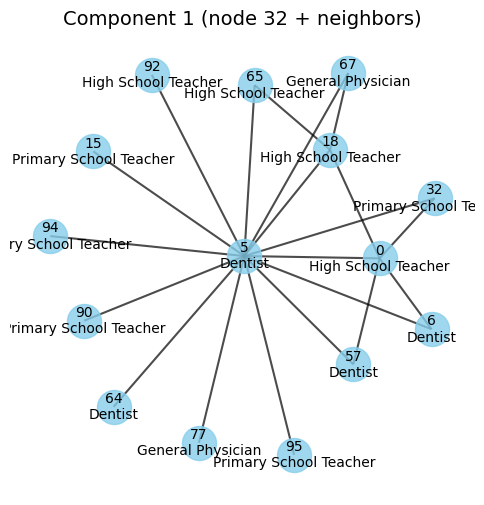

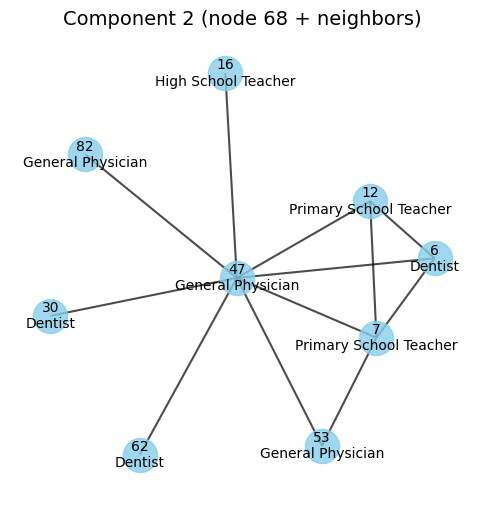

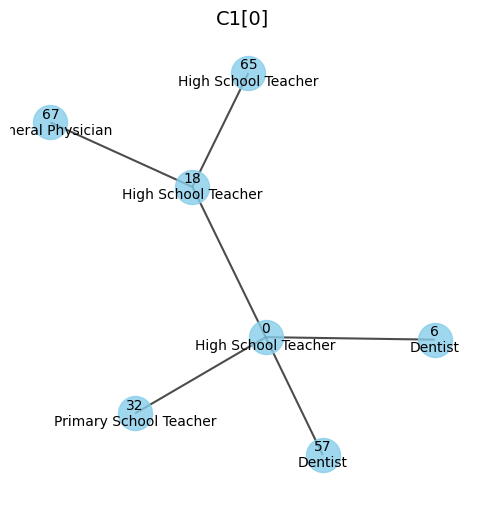

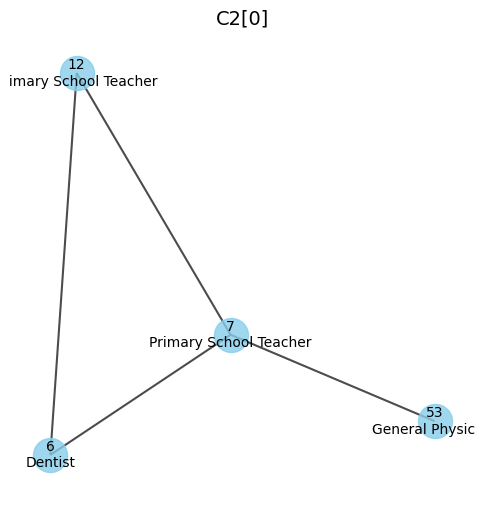

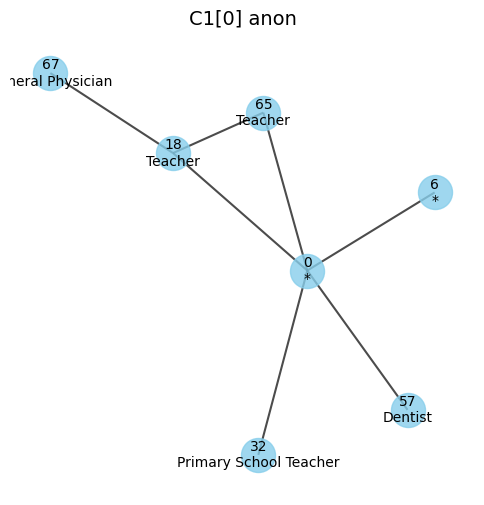

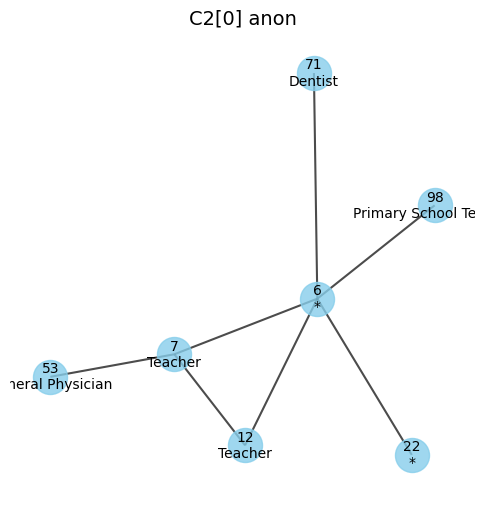

node 0 anonymized False
node 65 anonymized False
node 32 anonymized False
node 67 anonymized False
node 6 anonymized False
node 18 anonymized False
node 57 anonymized False
node 98 anonymized False
node 6 anonymized False
node 7 anonymized True
node 71 anonymized False
node 12 anonymized False
node 53 anonymized False
node 22 anonymized False
List 1 (size 6): [76, 13, 70, 50, 5, 47]
List 2 (size 7): [55, 27, 20, 48, 49, 40, 60]
List 3 (size 7): [16, 77, 26, 95, 45, 46, 30]
List 4 (size 5): [33, 87, 2, 56, 7]
List 5 (size 6): [78, 81, 88, 80, 94, 84]


In [29]:
# DEBUG CODE

# --- Plot both components ---
plot_component(N1, title="Component 1 (node 32 + neighbors)")
plot_component(N2, title="Component 2 (node 68 + neighbors)")

plot_component(C1[0], title="C1[0]")
plot_component(C2[0], title="C2[0]")

comp1_anon, comp2_anon = match_and_generalize_components(G, C1[0], C2[0], n1, n2, EquivalenceClassDict, label_domain)

plot_component(comp1_anon, title="C1[0] anon")
plot_component(comp2_anon, title="C2[0] anon")

for node in comp1_anon:
    print(f"node {node} anonymized {comp1_anon.nodes[node]['anonymized']}")

for node in comp2_anon:
    print(f"node {node} anonymized {comp2_anon.nodes[node]['anonymized']}")

# Print the resulting lists
for idx, lst in enumerate(lists, 1):
    print(f"List {idx} (size {len(lst)}): {lst}")

In [16]:
# DEBUG CODE
def graph_diff(before: nx.Graph, after: nx.Graph):
    """
    Compare two NetworkX graphs and report meaningful differences:
    nodes added/removed, edges added/removed, label changes.
    
    Returns:
        changed (bool): True if any meaningful change occurred
        diff (dict): Dictionary with detailed differences
    """
    # Nodes added/removed
    nodes_added = set(after.nodes()) - set(before.nodes())
    nodes_removed = set(before.nodes()) - set(after.nodes())
    
    # Edges added/removed
    edges_added = set(after.edges()) - set(before.edges())
    edges_removed = set(before.edges()) - set(after.edges())
    
    # Nodes with label changes (or any 'label' attribute)
    label_changed_nodes = []
    for n in set(before.nodes()).intersection(after.nodes()):
        before_label = before.nodes[n].get('label')
        after_label = after.nodes[n].get('label')
        if before_label != after_label:
            label_changed_nodes.append(n)

    anon_label_changed_nodes = []
    for n in set(before.nodes()).intersection(after.nodes()):
        before_label = before.nodes[n].get('anonymized')
        after_label = after.nodes[n].get('anonymized')
        if before_label != after_label:
            anon_label_changed_nodes.append(n)
    
    # Combine results
    changed = (nodes_added or nodes_removed or edges_added or edges_removed or label_changed_nodes or anon_label_changed_nodes)
    
    diff = {
        "nodes_added": nodes_added,
        "nodes_removed": nodes_removed,
        "edges_added": edges_added,
        "edges_removed": edges_removed,
        "label_changed_nodes": label_changed_nodes,
        "anon_label_changed_nodes": anon_label_changed_nodes
    }
    
    return changed, diff

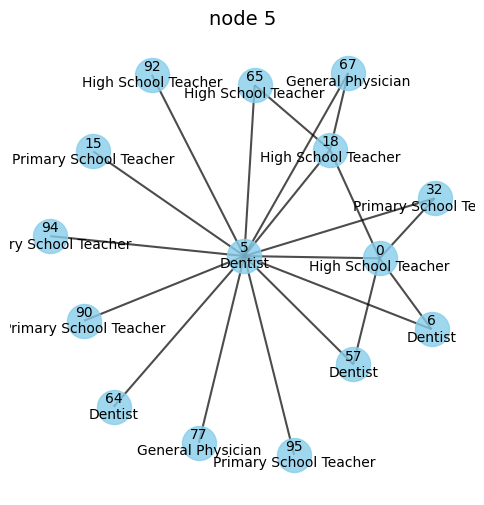

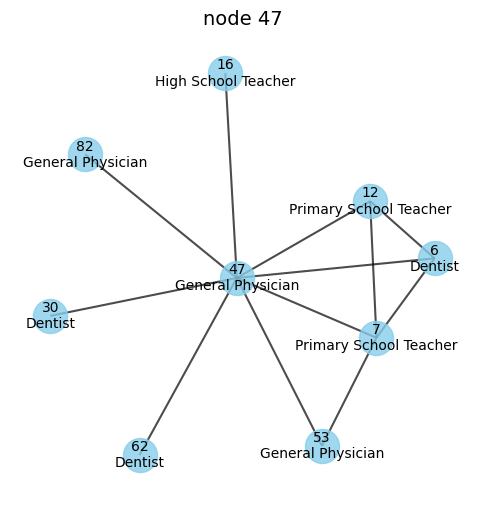

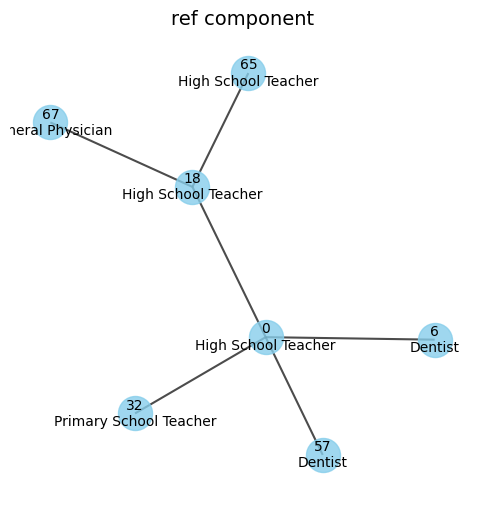

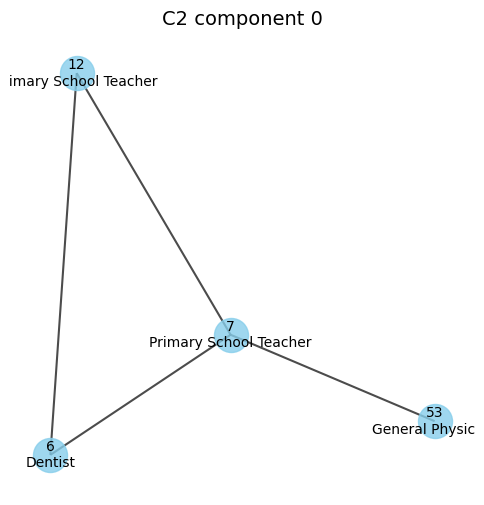

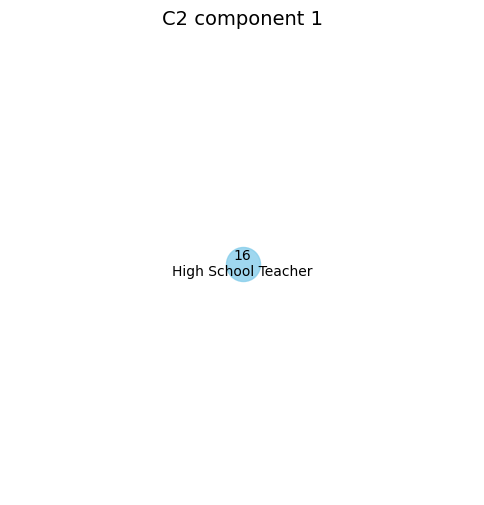

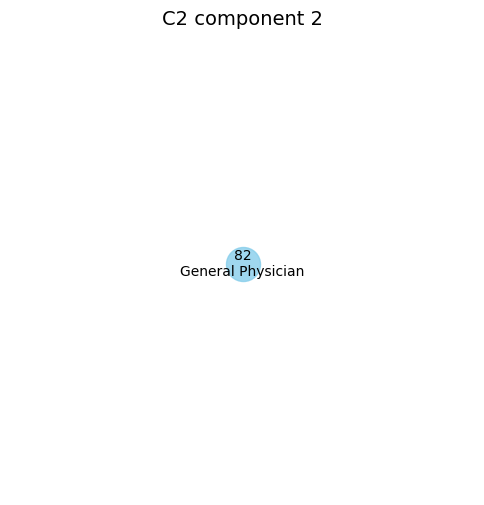

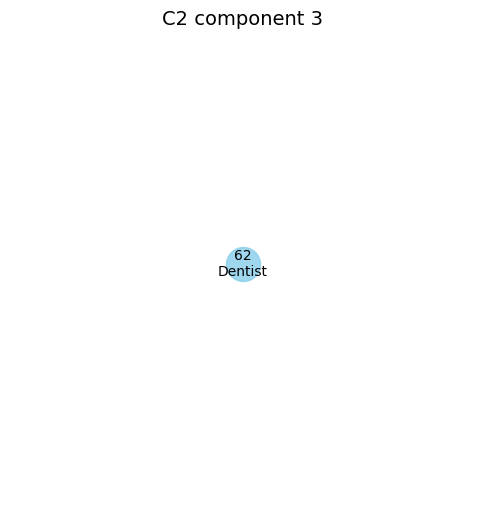

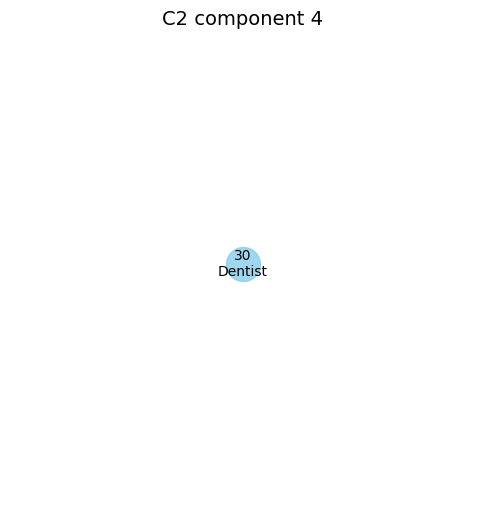

TypeError: most_similar_component() missing 1 required positional argument: 'label_domain'

In [31]:
# DEBUG CODE

# the graph did not change when executing most_similar_component, the function does not affect it in any of its parts
# large alpha give a huge importance to labels, prioritizing small components match with perfect labels over smae-size components with different labels

plot_component(N1, title=f"node {n1}")
plot_component(N2, title=f"node {n2}")
plot_component(C1[0], title="ref component")
i = 0
for c in C2:
    plot_component(c, title=f"C2 component {i}")
    i += 1

before = G.copy()
original_comp, ref_comp_anon, src_comp_anon = most_similar_component(G, C1[0], C2, n1, n2, EquivalenceClassDict, label_domain, alpha=1, beta=1, gamma=1)
after = G.copy()

plot_component(original_comp, title="most similar component")
plot_component(ref_comp_anon, title="ref anon")
plot_component(src_comp_anon, title="most similar anon")

changed, diff = graph_diff(before, after)

if changed:
    result = True
else:
    result = False
print(f"Graph meaningfully changed? {result}")
print("Differences:", diff)



In [17]:
def update_graph(G: nx.Graph, c_u_anon: nx.Graph, c_v_anon: nx.Graph, u: int, v: int): # deterministic & tested

    G.add_nodes_from(c_u_anon.nodes(data=True))  # include attributes
    G.add_edges_from(c_u_anon.edges(data=True))  # include attributes
    for node in c_u_anon:
        G.add_edge(u, node) # if i added a vertex to a component, this link is missing

    G.add_nodes_from(c_v_anon.nodes(data=True))  # include attributes
    G.add_edges_from(c_v_anon.edges(data=True))  # include attributes
    for node in c_v_anon:
        G.add_edge(v, node)

In [ ]:
original_G = G.copy()

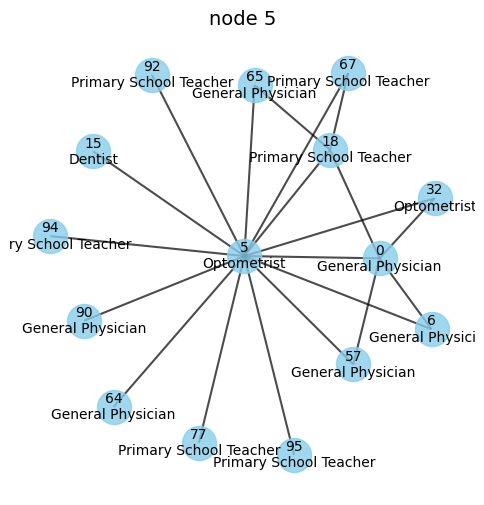

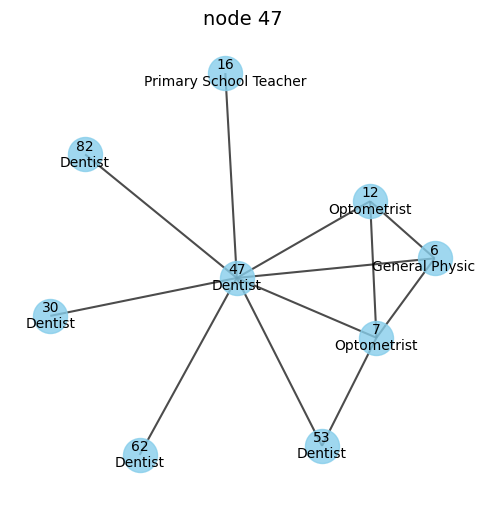

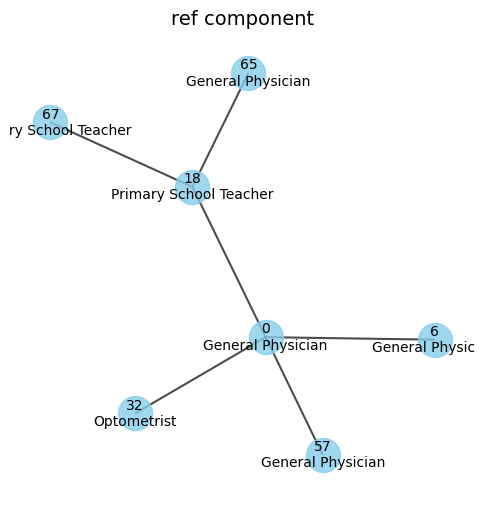

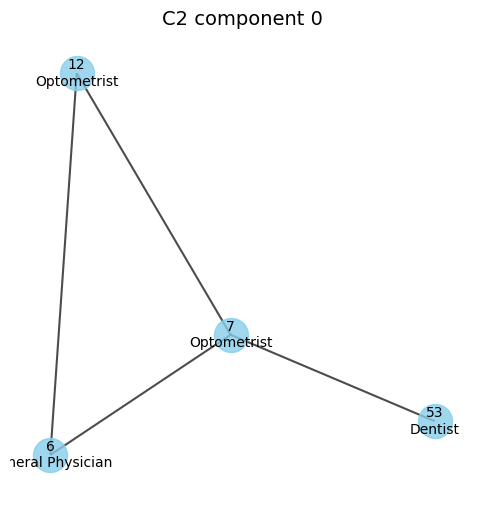

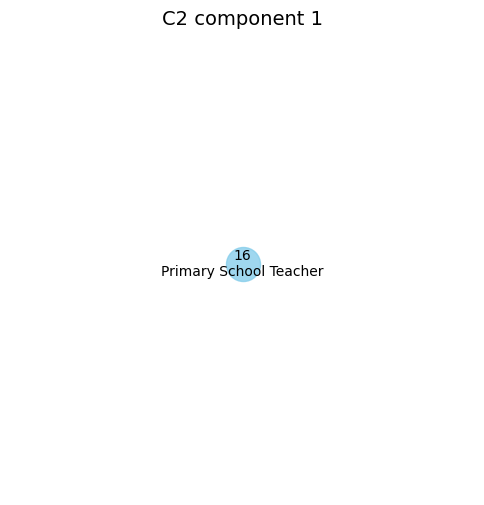

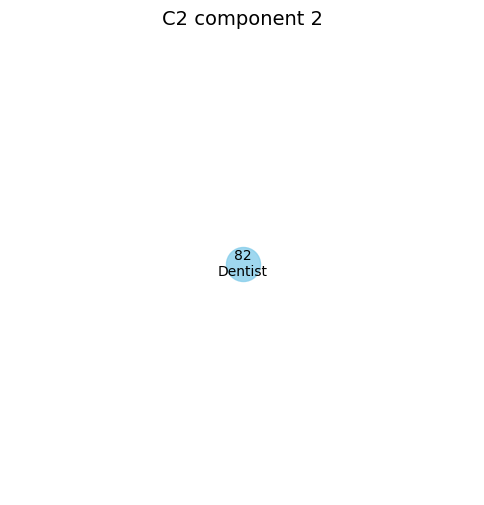

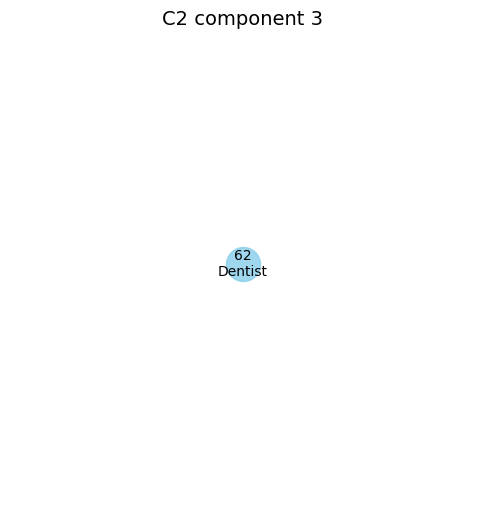

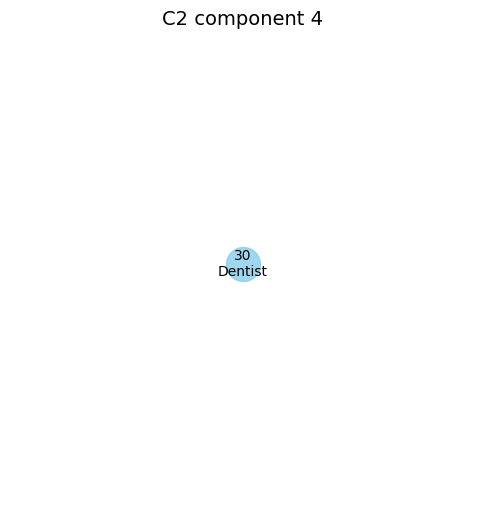

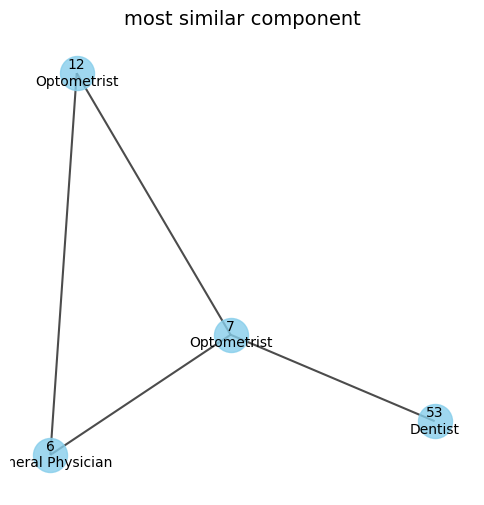

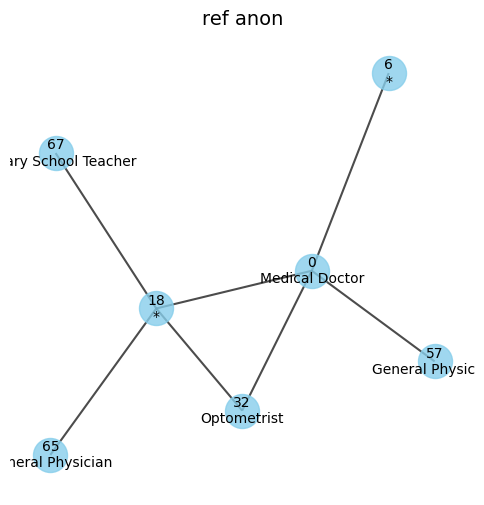

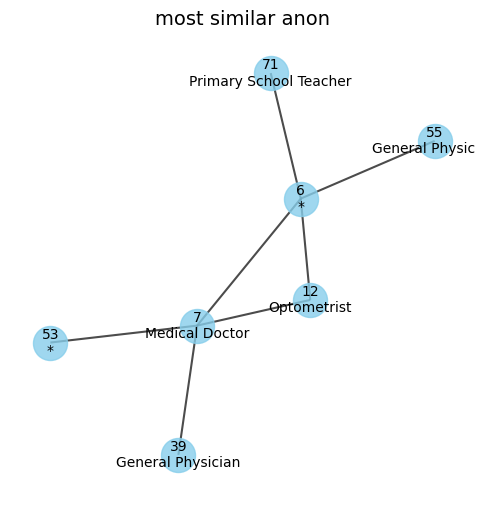

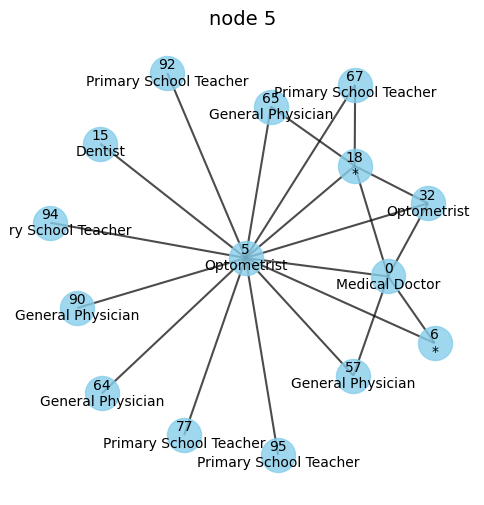

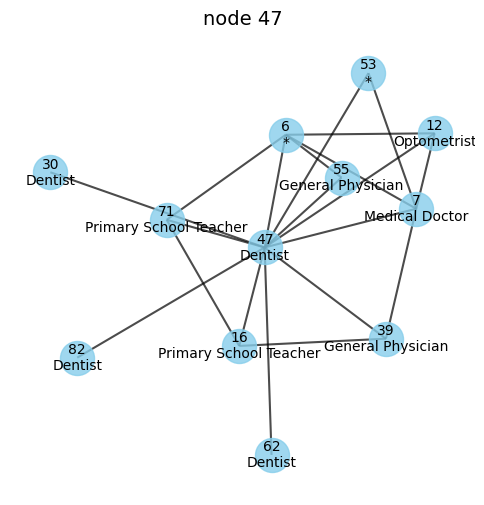

In [ ]:
# DEBUG CODE
G = original_G.copy()
plot_component(G.subgraph(list(G.neighbors(n1)) + [n1]), title=f"node {n1}")
plot_component(G.subgraph(list(G.neighbors(n2)) + [n2]), title=f"node {n2}")
plot_component(C1[0], title="ref component")
i = 0
for c in C2:
    plot_component(c, title=f"C2 component {i}")
    i += 1

original_comp, ref_comp_anon, src_comp_anon = most_similar_component(G, C1[0], C2, n1, n2, EquivalenceClassDict, label_domain, alpha=1, beta=1, gamma=1)

plot_component(original_comp, title="most similar component")
plot_component(ref_comp_anon, title="ref anon")
plot_component(src_comp_anon, title="most similar anon")

update_graph(G, ref_comp_anon, src_comp_anon, n1, n2)

plot_component(G.subgraph(list(G.neighbors(n1)) + [n1]), title=f"node {n1}")
plot_component(G.subgraph(list(G.neighbors(n2)) + [n2]), title=f"node {n2}")

In [73]:
def build_component(G: nx.Graph, ref_comp: nx.Graph, ref_node: int, src_node: int, EquivalenceClassDict: dict, label_domain: LabelDomain) -> nx.Graph: # tested & deterministic

    node_map_1_2 = {}
    node_map_2_1 = {}
    anonymized = {n: data['anonymized'] for n, data in G.nodes(data=True)}

    for ref_node_in_comp in sorted(ref_comp.nodes()):
        # as before + not in NeighborG(ref_node)
        constraints = build_constraints(src_node, EquivalenceClassDict[src_node], anonymized, set(node_map_2_1.keys()), {ref_node}, set(G.neighbors(ref_node))) 
        
        new_vertex = find_missing_matching_vertex(G, node, anonymized, constraints, label_domain)

        if new_vertex is None:
            print("Empty vertex")
        else:
            print(f"New vertex found in build_component: {new_vertex} matching {node}")

        if anonymized[new_vertex]:
            for eq_node in EquivalenceClassDict[new_vertex]:
                anonymized[eq_node] = False

        node_map_1_2[ref_node_in_comp] = new_vertex
        node_map_2_1[new_vertex] = ref_node_in_comp

    src_comp = G.subgraph(node_map_2_1.keys())

    print("node_map_1_2: ", node_map_1_2)
    print("node_map_2_1: ", node_map_2_1)
    print("ref_comp node: ", list(ref_comp.nodes()))
    print("node_map_1_2: ", list(src_comp.nodes()))
    ref_comp_anon, src_comp_anon = make_components_isomoprhic(ref_comp, src_comp, node_map_1_2, node_map_2_1, label_domain)

    return ref_comp_anon, src_comp_anon

In [ ]:
G = original_G.copy()

n1, n2 = 33, 70

num_lists = 5
lists = []
start = 0
for i in range(num_lists):
    remaining_lists = num_lists - i
    remaining_nodes = len(nodes) - start
    
    # Minimum and maximum for this list
    min_size = k1
    max_size = min(k2, remaining_nodes - (remaining_lists - 1) * k1)
    
    size = random.randint(min_size, max_size)
    
    lists.append(nodes[start:start+size])
    start += size
lists[0].extend([n1, n2])

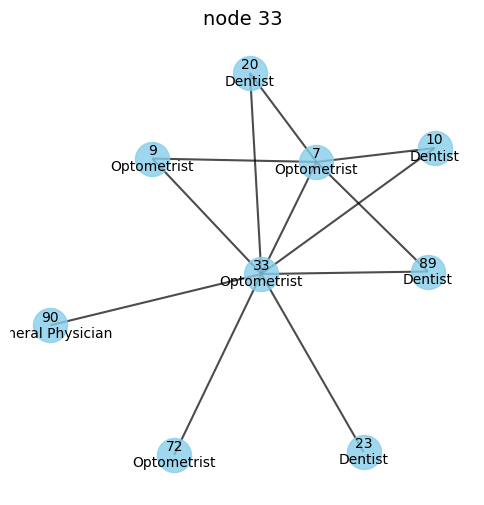

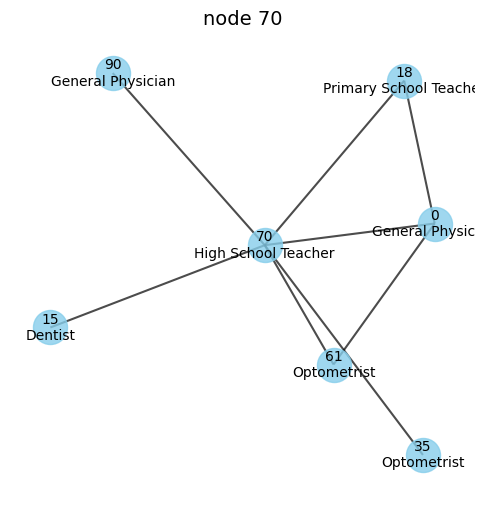

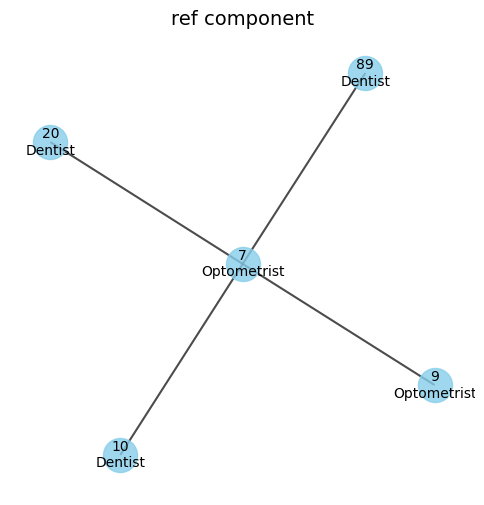

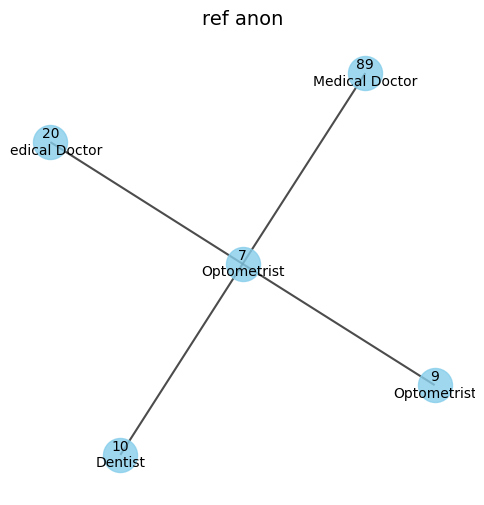

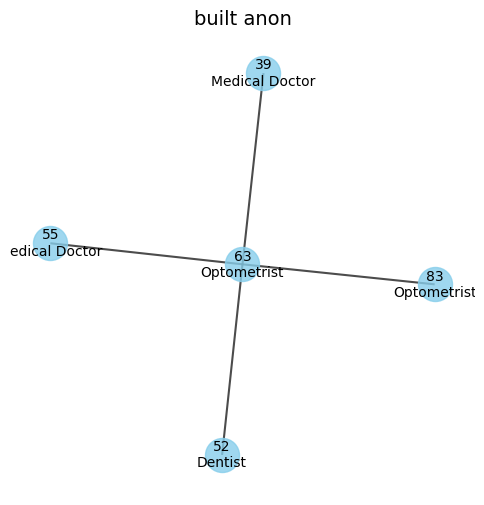

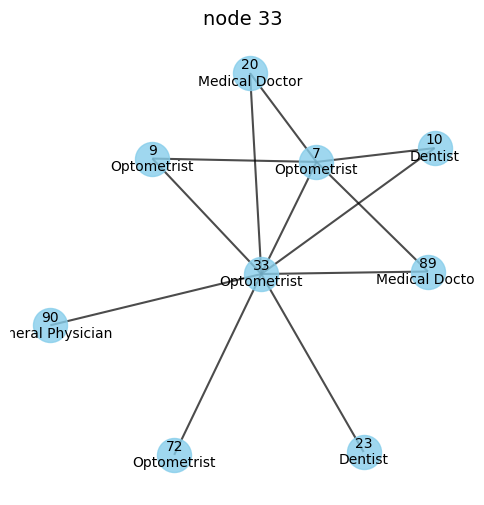

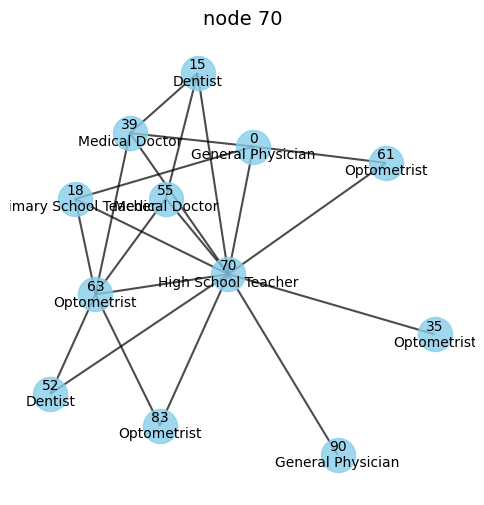

In [ ]:
G = original_G.copy()

EquivalenceClassDict = {} # Build the equivalence class dictionary from the lists
for eq_class in lists:
    for node in eq_class:
        EquivalenceClassDict[node] = list(eq_class)

N1 = G.subgraph(list(G.neighbors(n1)) + [n1])
N2 = G.subgraph(list(G.neighbors(n2)) + [n2])
C1 = [N1.subgraph(c) for c in nx.connected_components(N1.subgraph(list(N1.neighbors(n1))))]
C2 = [N2.subgraph(c) for c in nx.connected_components(N2.subgraph(list(N2.neighbors(n2))))]

plot_component(G.subgraph(list(G.neighbors(n1)) + [n1]), title=f"node {n1}")
plot_component(G.subgraph(list(G.neighbors(n2)) + [n2]), title=f"node {n2}")
plot_component(C1[0], title="ref component")

ref_comp_anon, src_comp_anon = build_component(G, C1[0], n1, n2, EquivalenceClassDict, label_domain)

plot_component(ref_comp_anon, title="ref anon")
plot_component(src_comp_anon, title="built anon")

update_graph(G, ref_comp_anon, src_comp_anon, n1, n2)

plot_component(G.subgraph(list(G.neighbors(n1)) + [n1]), title=f"node {n1}")
plot_component(G.subgraph(list(G.neighbors(n2)) + [n2]), title=f"node {n2}")

Testato solo fino a questo punto, da qui in poi iniziano i miracoli

In [19]:
# generalize the two centers labels
def generalize_labels(G: nx.Graph, u: int, v: int, label_domain: LabelDomain):
    label_u = G.nodes[u]['label']
    label_v = G.nodes[v]['label']
    general_label = label_domain.find_label_common_parent(label_u, label_v)
    G.nodes[u]['label'] = general_label 
    G.nodes[v]['label'] = general_label

In [31]:
def get_neighborhood_components(G: nx.Graph, u: int, v: int): # deterministic

    # Neighborhood subgraphs
    Nu = G.subgraph(sorted(G.neighbors(u))).copy()
    Nv = G.subgraph(sorted(G.neighbors(v))).copy()

    # Connected components of the neighborhoods
    Cu = [sorted(c) for c in nx.connected_components(Nu)]
    Cv = [sorted(c) for c in nx.connected_components(Nv)]

    # Sort components by smallest node ID (deterministic ordering)
    Cu.sort(key=lambda nodes: nodes[0] if nodes else float('inf'))
    Cv.sort(key=lambda nodes: nodes[0] if nodes else float('inf'))

    print(f"Number of components node {u}: {len(Cu)}")
    print(f"Number of components node {v}: {len(Cv)}")

    # Build component subgraphs with deterministic IDs
    component_graphs = {
        u: {i: Nu.subgraph(nodes).copy() for i, nodes in enumerate(Cu)},
        v: {i: Nv.subgraph(nodes).copy() for i, nodes in enumerate(Cv)}
    }

    unmatched_components = {
        u: set(component_graphs[u].keys()),
        v: set(component_graphs[v].keys())
    }

    return component_graphs, unmatched_components

In [32]:
def find_perfect_comp_matches(u, v, component_graphs, unmatched_components): # deterministic

    for cu_id in sorted(unmatched_components[u]): 
        c_u = component_graphs[u][cu_id]
        matched_cv_id = None
        for cv_id in sorted(unmatched_components[v]):
            c_v = component_graphs[v][cv_id]
            if minimumDFScode(c_u) == minimumDFScode(c_v):
                matched_cv_id = cv_id
                break
        if matched_cv_id is not None:
            unmatched_components[u].remove(cu_id)
            unmatched_components[v].remove(matched_cv_id)
            print("1 perfect component match!")
    
    return unmatched_components

In [67]:
def anonymize_pair(G: nx.Graph, u: int, v: int, label_domain: LabelDomain, VertexList: list, EquivalenceClassDict: dict, alpha: float, beta: float, gamma: float) -> tuple[nx.Graph, nx.Graph]:

    # Get neighborhood components
    component_graphs, unmatched_components = get_neighborhood_components(G, u, v) # deterministic

    # generalize the two centers labels
    generalize_labels(G, u, v, label_domain)

    # find perfect matches
    unmatched_components = find_perfect_comp_matches(u, v, component_graphs, unmatched_components) # deterministic

    while unmatched_components[u] and unmatched_components[v]:
        # choose the largest component
        largest_u_id = max(unmatched_components[u],
            key=lambda cid: (
                component_graphs[u][cid].number_of_nodes(),
                -min(component_graphs[u][cid].nodes())))
        
        largest_v_id = max(unmatched_components[v],
            key=lambda cid: (
                component_graphs[v][cid].number_of_nodes(),
                -min(component_graphs[v][cid].nodes())))
        
        largest_u_component = component_graphs[u][largest_u_id]
        largest_v_component = component_graphs[v][largest_v_id]
        
        if largest_u_component.number_of_nodes() >= largest_v_component.number_of_nodes():
            target, source = u, v
            largest_id, largest = largest_u_id, largest_u_component
        else:
            target, source = v, u
            largest_id, largest = largest_v_id, largest_v_component
        
        most_similar_id, target_anon, source_anon = most_similar_component(
                G,
                largest_u_id,
                component_graphs=component_graphs,
                unmatched_component_ids=unmatched_components[source],
                ref_node=target,
                src_node=source,
                EquivalenceClassDict=EquivalenceClassDict,
                label_domain=label_domain,
                alpha=alpha,
                beta=beta,
                gamma=gamma
            )
        #TODO: manage the update of anon new vertex
        # most_similar_c is always equal or smaller in |V| w.r.t. largest_c -> if nodes are added, are added here

        added_nodes = source_anon.nodes() - component_graphs[source][most_similar_id].nodes()

        update_graph(G, target_anon, source_anon, target, source)

        labels = nx.get_node_attributes(G.subgraph(list(added_nodes)), 'anonymized')
        added_anon_nodes = [n for n, v in labels.items() if v == True]

        for added_anon in added_anon_nodes:
                eq_class_nodes = EquivalenceClassDict[added_anon]

                # sync changes -> means anonymizing again
                #for eq_class_node in eq_class_nodes:
                #    if eq_class_node != added_anon:
                #        anonymize_pair(G, added_anon, eq_class_node, label_domain, VertexList, EquivalenceClassDict, alpha, beta, gamma)

                # make them unanon
                for n in eq_class_nodes:
                    G.nodes[n]['anonymized'] = False
                
                # add to vertex list
                VertexList.extend(eq_class_nodes)
                VertexList.sort(key=lambda x: neighborhood_size_key(G, x))
                
                # remove equality class
                for eq_class_node in eq_class_nodes:
                    del EquivalenceClassDict[eq_class_node]
                
        unmatched_components[target].remove(largest_id)
        unmatched_components[source].remove(most_similar_id)
        print("1 partial component match!")

    # orphaned components
    if unmatched_components[u] and not unmatched_components[v]:
    # Cv is empty, Cu has extra components
        target = u
        source = v
        extras = unmatched_components[u].copy()
    elif not unmatched_components[u] and unmatched_components[v]:
    # Cu is empty, Cv has extra components
        target = v
        source = u
        extras = unmatched_components[v].copy()
    else:
        extras = []

    for cid in extras:
        extra = component_graphs[target][cid]
        print("Component without match: ", list(extra.nodes()))
        target_anon, source_anon = build_component(G, extra, target, source, EquivalenceClassDict, label_domain) # anon must be copies

        ## NEED TO MODIFY THE GRAPH -> in place
        update_graph(G, target_anon, source_anon, target, source)
        #TODO: manage the update of anon new vertex
        labels = nx.get_node_attributes(source_anon, 'anonymized')
        added_anon_nodes = [n for n, v in labels.items() if v == True]

        for added_anon in added_anon_nodes:
            eq_class_nodes = EquivalenceClassDict[added_anon]

            # sync changes -> means anonymizing again
            #for eq_class_node in eq_class_nodes:
            #    if eq_class_node != added_anon:
            #        anonymize_pair(G, added_anon, eq_class_node, label_domain, VertexList, EquivalenceClassDict, alpha, beta, gamma)

            # make them unanon
            for n in eq_class_nodes:
                G.nodes[n]['anonymized'] = False
            
            # add to vertex list
            VertexList.extend(eq_class_nodes)
            VertexList.sort(key=lambda x: neighborhood_size_key(G, x))
            
            # remove equality class
            for eq_class_node in eq_class_nodes:
                del EquivalenceClassDict[eq_class_node]

        unmatched_components[target].remove(cid)
        print("1 ad hoc component match!")

In [ ]:
import matplotlib.pyplot as plt

def plot_colored_graph(G, special_nodes, special_color='green', default_color='lightblue'):
    # Start with all nodes as default color
    node_colors = {node: default_color for node in G.nodes()}
    
    # Highlight special nodes and their neighbors
    for node in special_nodes:
        node_colors[node] = special_color
        for neighbor in G.neighbors(node):
            node_colors[neighbor] = special_color
    
    # Get the list of colors in the order of G.nodes()
    colors = [node_colors[node] for node in G.nodes()]
    
    # Draw the graph
    pos = nx.spring_layout(G)  # nice layout
    nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=800)
    plt.show()

In [56]:
def anonymize_graph(G: nx.Graph, k: int, label_domain: LabelDomain, alpha: float, beta: float, gamma: float)-> nx.Graph:
    
    G_anon = G.copy()
    VertexList = sorted(G_anon.nodes, key=lambda v: neighborhood_size_key(G, v), reverse=True)  # descending order

    EquivalenceClassDict = {}
    nx.set_node_attributes(G_anon, False, 'anonymized')

    while VertexList:
        SeedVertex = VertexList.pop(0) # remove and return
        label_seed = G_anon.nodes[SeedVertex]['label']
        deg_seed = G_anon.degree[SeedVertex]

        costs = {}
        for v in VertexList:
            # order by cost based on degree difference + NPC
            label_v = G_anon.nodes[v]['label']
            deg_v = G_anon.degree[v]

            general_label = label_domain.find_label_common_parent(label_seed, label_v)
            costs[v] = abs(deg_seed - deg_v) + label_domain.normalized_certainty_penalty(general_label)

        # select candidate set
        if len(VertexList) >= (2*k - 1):
            sorted_cost = sorted(costs.items(), key=lambda item: item[1])
            candidate_set = [node for node, _ in sorted_cost[:k-1]]

        else: 
            candidate_set = VertexList

        for v in [SeedVertex] + candidate_set:
            EquivalenceClassDict[v] = [SeedVertex] + candidate_set

        u1 = candidate_set[0]
        print(f"Processing: {SeedVertex} - {u1}")
        anonymize_pair(G_anon, SeedVertex, u1, label_domain, VertexList, EquivalenceClassDict, alpha, beta, gamma)
        # i need tu update G_anon -> incrementally anonymize in place.
        G_anon.nodes[SeedVertex]['anonymized'] = True
        G_anon.nodes[u1]['anonymized'] = True
        
        plot_colored_graph(G, candidate_set + [SeedVertex])
        
        VertexList.remove(u1)

        # i need to incrementally improve G_anon
        for j in range(2, len(candidate_set)):
            uj = candidate_set[j-1]

            for v in [SeedVertex] + candidate_set[:j-1]:
                anonymize_pair(G_anon, uj, v, label_domain, VertexList, EquivalenceClassDict, alpha, beta, gamma)

            G_anon.nodes[uj]['anonymized'] = True
            VertexList.remove(uj)

        print("End of eq class: ", [SeedVertex] + candidate_set)

    return G_anon

In [35]:
G_random = nx.gnp_random_graph(n=20, p=0.2, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain)

In [ ]:

u, v = 8, 9

plot_component(G_random, "Random Graph")

# Get neighborhood components
component_graphs, unmatched_components = get_neighborhood_components(G_random, u, v)
print(unmatched_components)
# generalize the two centers labels
generalize_labels(G_random, u, v, label_domain)

unmatched_components = find_perfect_comp_matches(u, v, component_graphs, unmatched_components)
print(unmatched_components)

Number of components node 8: 5
Number of components node 9: 4
{8: {0, 1, 2, 3, 4}, 9: {0, 1, 2, 3}}
1 perfect component match!
1 perfect component match!
1 perfect component match!
{8: {1, 2}, 9: {1}}


Processing: 8 - 9
Number of components node 8: 5
Number of components node 9: 4
1 perfect component match!
1 perfect component match!
1 perfect component match!
1 partial component match!
Component without match:  [3, 6]
New vertex found in build_component: 18 matching 5
New vertex found in build_component: 1 matching 5
node_map_1_2:  {3: 18, 6: 1}
node_map_2_1:  {18: 3, 1: 6}
ref_comp node:  [3, 6]
node_map_1_2:  [1, 18]
1 ad hoc component match!


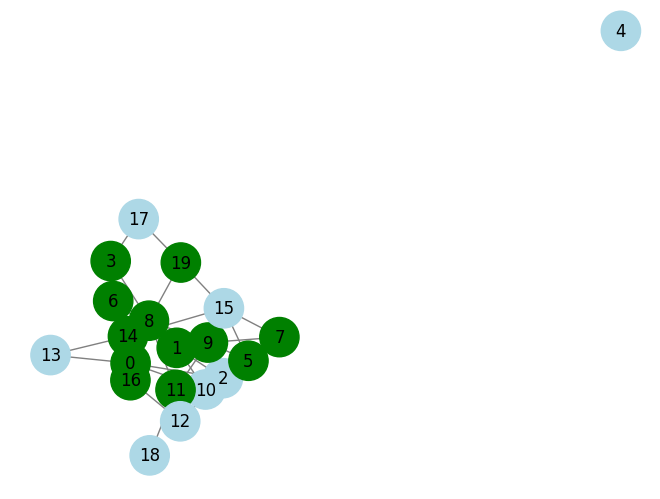

End of eq class:  [8, 9]
Processing: 14 - 11
Number of components node 14: 5
Number of components node 11: 2
1 perfect component match!
1 partial component match!
Component without match:  [9]
New vertex found in build_component: 3 matching 5
node_map_1_2:  {9: 3}
node_map_2_1:  {3: 9}
ref_comp node:  [9]
node_map_1_2:  [3]
1 ad hoc component match!
Component without match:  [15]
New vertex found in build_component: 12 matching 5
node_map_1_2:  {15: 12}
node_map_2_1:  {12: 15}
ref_comp node:  [15]
node_map_1_2:  [12]
1 ad hoc component match!
Component without match:  [16]
New vertex found in build_component: 12 matching 5
node_map_1_2:  {16: 12}
node_map_2_1:  {12: 16}
ref_comp node:  [16]
node_map_1_2:  [12]
1 ad hoc component match!


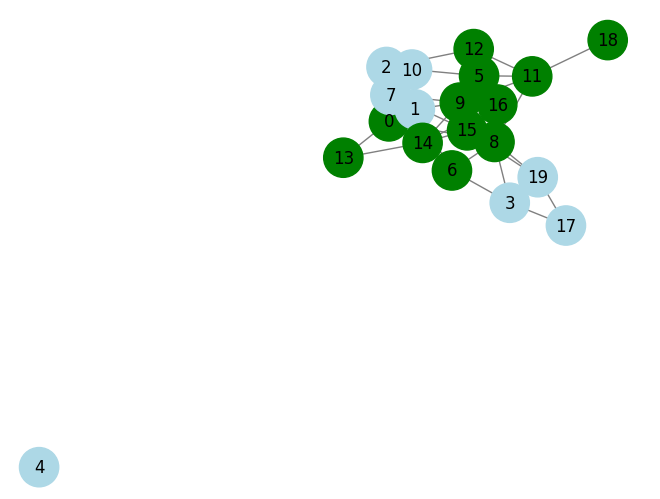

End of eq class:  [14, 11]
Processing: 2 - 0
Number of components node 2: 3
Number of components node 0: 3
1 perfect component match!
1 partial component match!
1 partial component match!


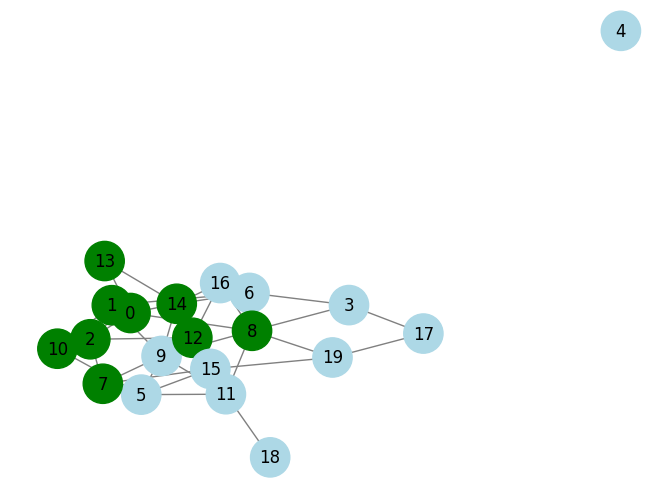

End of eq class:  [2, 0]
Processing: 10 - 6
Number of components node 10: 2
Number of components node 6: 3
1 perfect component match!
1 partial component match!
Component without match:  [14]
New vertex found in build_component: 19 matching 5
node_map_1_2:  {14: 19}
node_map_2_1:  {19: 14}
ref_comp node:  [14]
node_map_1_2:  [19]
1 ad hoc component match!


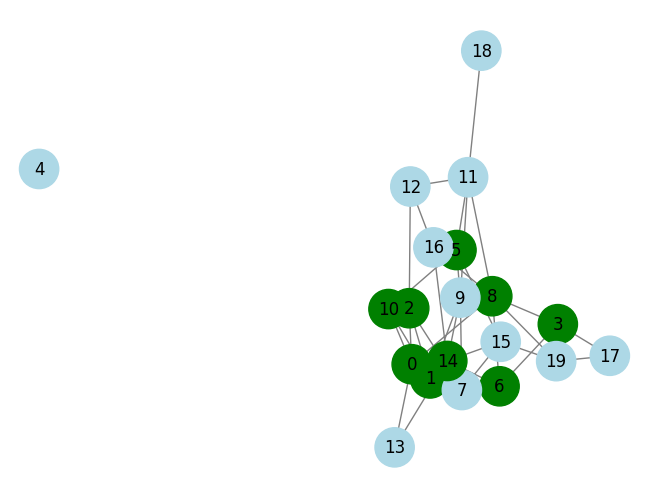

End of eq class:  [10, 6]
Processing: 5 - 15
Number of components node 5: 3
Number of components node 15: 3
1 perfect component match!
1 perfect component match!
1 partial component match!


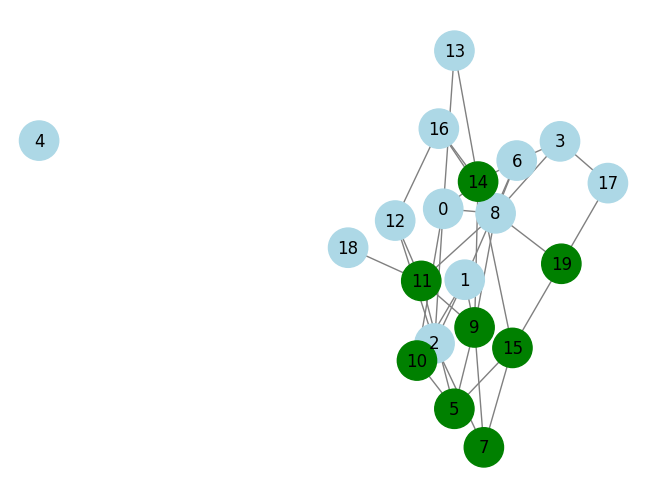

End of eq class:  [5, 15]
Processing: 1 - 7
Number of components node 1: 3
Number of components node 7: 2
1 perfect component match!
1 partial component match!
Component without match:  [2, 10]
New vertex found in build_component: 3 matching 5
New vertex found in build_component: 16 matching 5
node_map_1_2:  {2: 3, 10: 16}
node_map_2_1:  {3: 2, 16: 10}
ref_comp node:  [2, 10]
node_map_1_2:  [16, 3]
1 ad hoc component match!


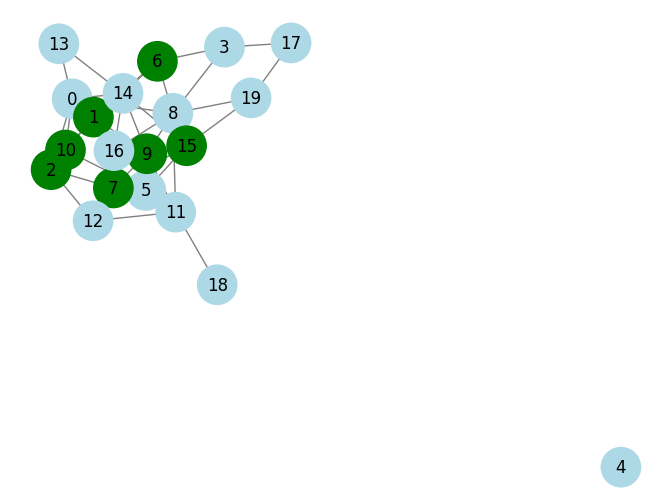

End of eq class:  [1, 7]
Processing: 3 - 16
Number of components node 3: 2
Number of components node 16: 1
1 partial component match!
Component without match:  [17]
New vertex found in build_component: 19 matching 5
node_map_1_2:  {17: 19}
node_map_2_1:  {19: 17}
ref_comp node:  [17]
node_map_1_2:  [19]
1 ad hoc component match!


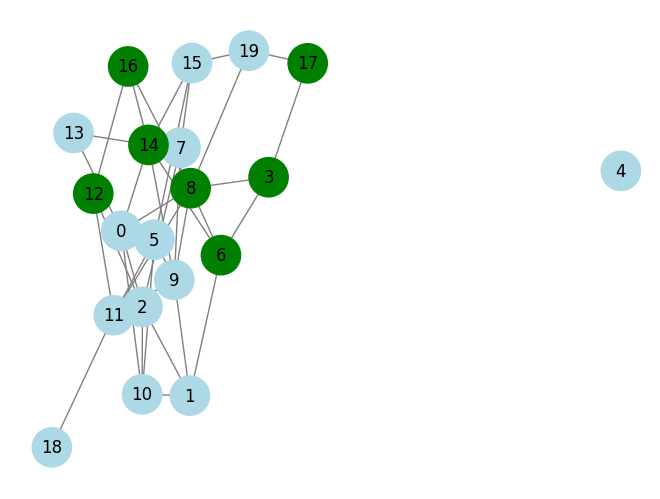

End of eq class:  [3, 16]
Processing: 19 - 13
Number of components node 19: 4
Number of components node 13: 1
1 partial component match!
Component without match:  [10]
New vertex found in build_component: 4 matching 5
node_map_1_2:  {10: 4}
node_map_2_1:  {4: 10}
ref_comp node:  [10]
node_map_1_2:  [4]
1 ad hoc component match!
Component without match:  [15]
New vertex found in build_component: 4 matching 5
node_map_1_2:  {15: 4}
node_map_2_1:  {4: 15}
ref_comp node:  [15]
node_map_1_2:  [4]
1 ad hoc component match!
Component without match:  [17]
New vertex found in build_component: 4 matching 5
node_map_1_2:  {17: 4}
node_map_2_1:  {4: 17}
ref_comp node:  [17]
node_map_1_2:  [4]
1 ad hoc component match!


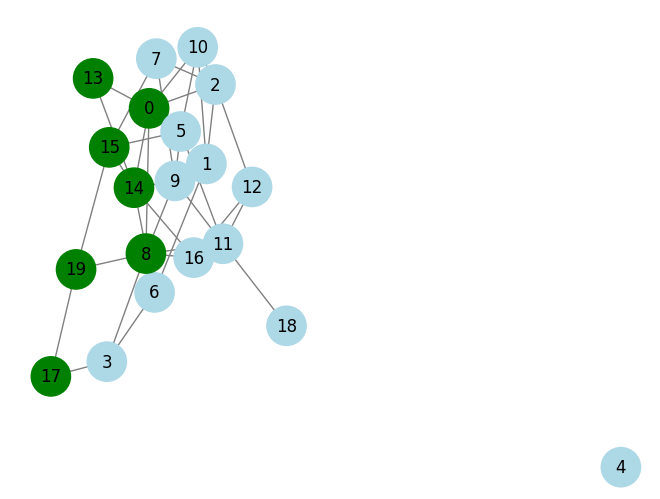

End of eq class:  [19, 13]
Processing: 12 - 4
Number of components node 12: 2
Number of components node 4: 1
1 partial component match!
Component without match:  [11]
New vertex found in build_component: 5 matching 5
node_map_1_2:  {11: 5}
node_map_2_1:  {5: 11}
ref_comp node:  [11]
node_map_1_2:  [5]
1 ad hoc component match!


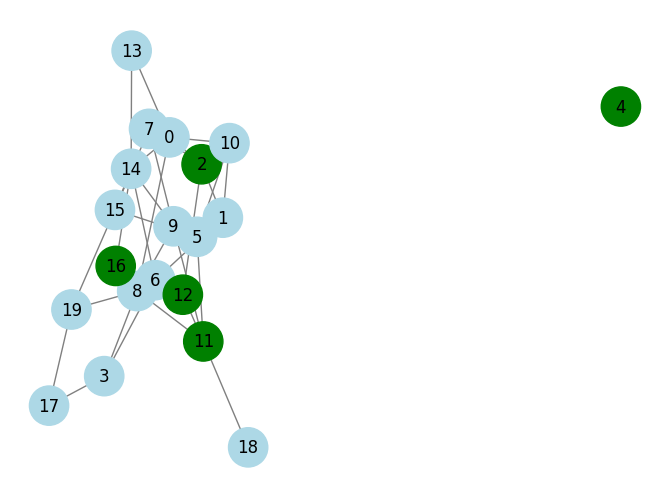

End of eq class:  [12, 4]
Processing: 15 - 5
Number of components node 15: 3
Number of components node 5: 3
1 perfect component match!
1 perfect component match!
1 partial component match!


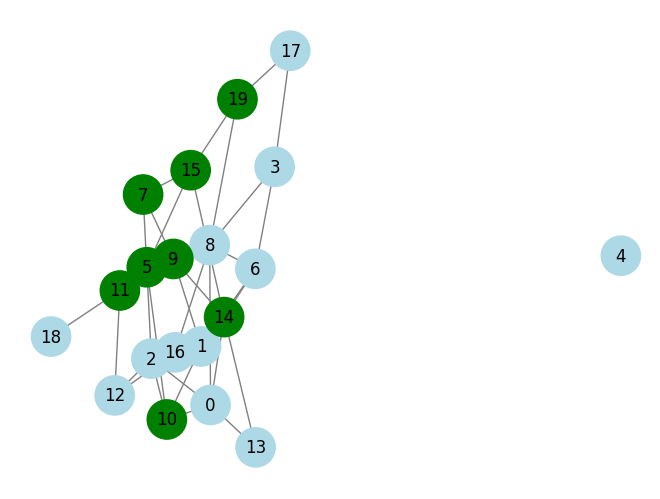

End of eq class:  [15, 5]
Processing: 18 - 17
Number of components node 18: 1
Number of components node 17: 1


KeyError: 16

In [87]:
G_anon = anonymize_graph(G_random, 2, label_domain, 1, 1, 1)

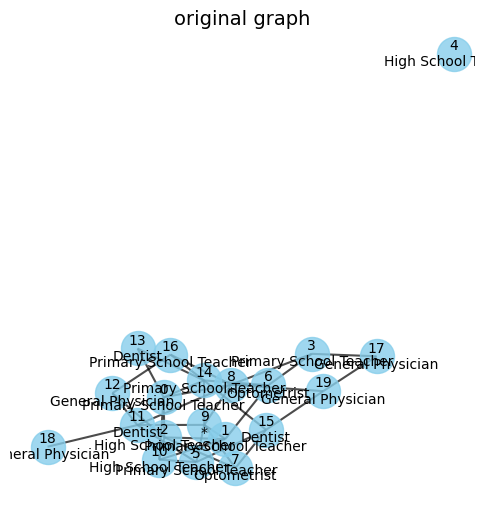

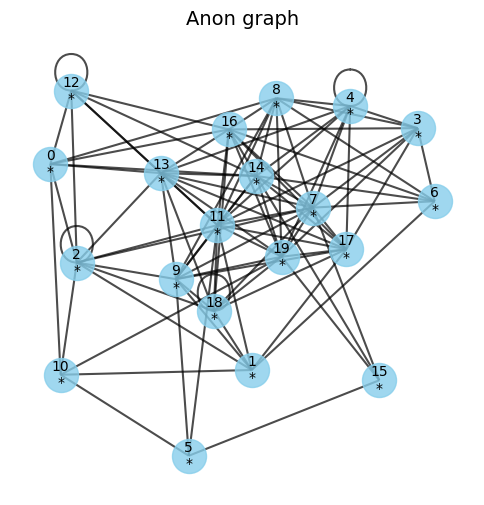

In [82]:
plot_component(G_random, "original graph")

plot_component(G_anon, "Anon graph")

In [83]:
nx.density(G_anon)

0.5052631578947369